<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/03_Fully_Connected_Neural_Networks.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Neural Networks - Fully Connected Neural Networks

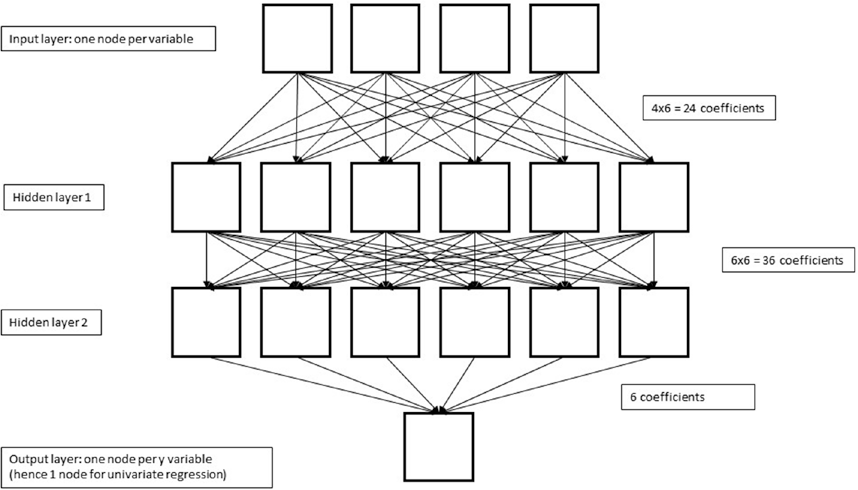

The model always contains an input
layer and an output layer. The input layer of the network contains one node for each
variable. The output layer contains the same number of nodes as there are output
variables. In the case of univariate regression, there is one output variable (the target
variable y). After the input, you go to the first hidden layer. The values of the
hidden layer are computed by multiplying the input by a weight and then passing
the value through an activation function. This combination of multiplication and
activation functions repeats itself in each node until arriving at the output node. This
model is called a fully connected model because each node is connected to each node in
the following layer.

In this example, we’ll do a forecast of the temperature 12 hours later. To do this, we create lagged variables for the independent variables and make a correct dataframe.
We have quite a lot of data, so we can add multiple lagged values to add the most
information possible to the model.



#### 1 - Importing Data

Data: Jena Climate dataset

Period of Record: From 2009 to 2016

Number of observations: 420551
Number of variables: 14
Variable name definitions:

1.   Date Time - sample date in DD.MM.YYYY hh:mm:ss format
1.   p (mbar): Atmospheric pressure measured in millibars (mbar).
1.   T (degC): Air temperature measured in degrees Celsius (°C).
1.   Tpot (K): Potential temperature measured in Kelvin (K).
1.   Tdew (degC): Dew point temperature measured in degrees Celsius (°C).
1.   rh (%): Relative humidity measured as a percentage (%).
1.   VPmax (mbar): Saturation vapor pressure measured in millibars (mbar).
1.   VPact (mbar): Actual vapor pressure measured in millibars (mbar).
1.   VPdef (mbar): Vapor pressure deficit measured in millibars (mbar).
1.   sh (g/kg): Specific humidity measured in grams per kilogram (g/kg).
1.   H2OC (mmol/mol): Water vapor concentration measured in millimoles per mole (mmol/mol).
1.   rho (g/m^3): Air density measured in grams per cubic meter (g/m^3).
1.   wv (m/s): Wind velocity measured in meters per second (m/s).
1.   max. wv (m/s): Maximum wind velocity measured in meters per second (m/s).
1.   wd (deg): Wind direction measured in degrees.


Source: https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip.

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3          3.33          3.11          0.22       1.94             3.12       1307.75      1.03           1.75     152.3
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4          3.23          3.02          0.21       1.89             3.03       1309.80      0.72           1.50     136.1
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9          3.21          3.01          0.20       1.88             3.02       1310.24      0.19           0.63     171.6
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2          3.26          3.07          0.19       1.92             3.08       1309.19      0.34           0.50     198.0
4  01.01.2009 00:50:00    996.51   

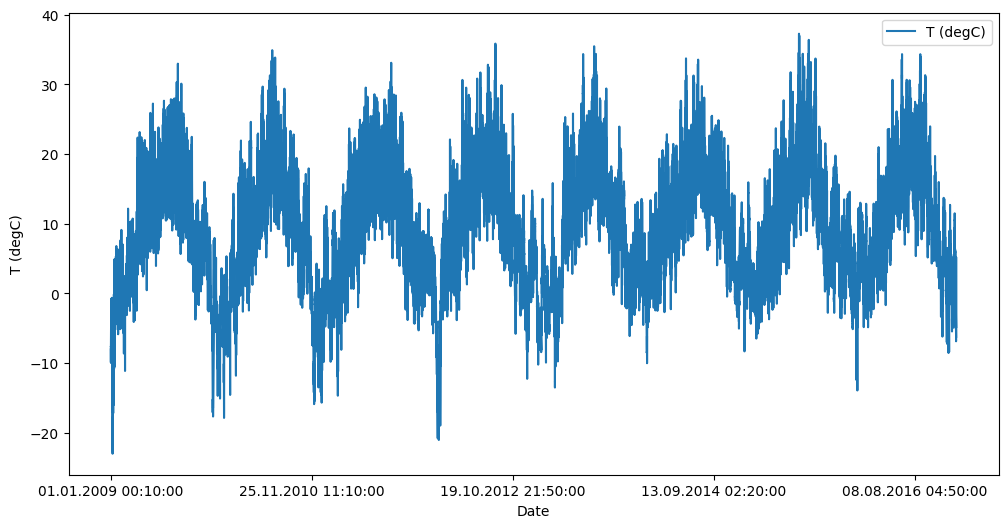

In [11]:
import keras
import pandas as pd
from zipfile import ZipFile
import os
import matplotlib.pyplot as plt

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)
del zip_file

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(df.head())

dates = df['Date Time']

# Display all data
ax = df.plot(x='Date Time', y='T (degC)',figsize=(12,6))
ax.set_ylabel('T (degC)')
ax.set_xlabel('Date')

plt.show()

df = df.drop('Date Time', axis=1)

cols = ['p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh',
'H2OC', 'rho', 'wv', 'mwv', 'wd']
df.columns = cols



#### 2 - Creating the lagged Dataset

In this example, we’ll do a forecast of the temperature 12 hours later. To do this, we create lagged variables for the independent variables and make a correct dataframe.
We have quite a lot of data, so we can add multiple lagged values to add the most information possible to the model

In [12]:
y = df.loc[2*72:,'T']
lagged_x = []
for lag in range(72,2*72,12):
  lagged = df.shift(lag)
  lagged.columns = [x + '.lag' + str(lag) for x in lagged.columns]
  lagged_x.append(lagged)
df = pd.concat(lagged_x, axis=1)
df = df.iloc[2*72:,:] #drop missing values due to lags

df.head()

(420407, 84)

#### 3 - Data Preparation - Scaling and Standardization

A neural network will not be able to learn if you do not standardize the input data. Standardizing means getting the data onto the same scale. As an example, we will use the MinMax scaler.
MinMax scaler brings a variable into the range of 0–1 by
subtracting the variable’s minimum from each value and then
dividing it by the range of the variable.

In [ ]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

#### 4 - Data Preparation - Principal Component Analysis (PCA)

PCA allows to take a dataset with a large number of variables and
reduce the number of variables into a projection onto a number of dimensions. Those dimensions will contain the larger part of the information and will contain much less noise. The idea is to make new variables, called components, based on combinations of strongly correlated variables. The component is a linear combination of the original variables.
For example, Rain and Humidity may be correlated and it can be more interesting to use the combination rather than the original variables.

To fit a PCA, you generally start with a PCA with all the components

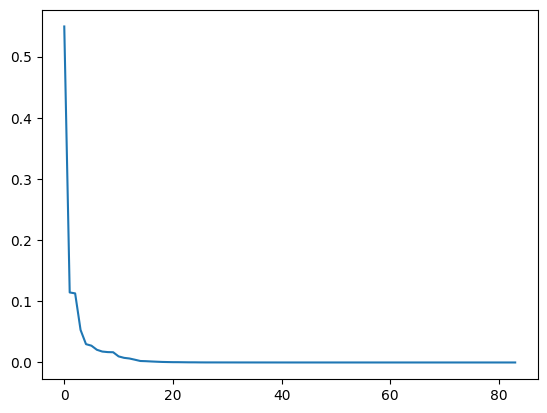

In [ ]:
# Fit a PCA with maximum number of components
from sklearn.decomposition import PCA
mypca = PCA()
mypca.fit(df)

# Make a scree plot
import matplotlib.pyplot as plt
plt.plot(mypca.explained_variance_ratio_)
plt.show()

In this plot, the x-axis shows the components from the first component to the last. The y variable shows the amount of variation that is captured in those components. The first five to ten components have much more information in them
than the higher components (those more to the right). For this reason, we retain 10 component rather than over 80

In [ ]:
mypca = PCA(10)
df = mypca.fit_transform(df)

#### 5 - The Neural Network With Keras

A general great first start is to start with a relatively simple network and work your way up from there. In this case, let’s start with a network using two dense layers with 64 nodes. That would make the architecture look as follows:

*   Optimizer: Adam
*   Learning rate: 0.01
*   Batch size: 32 (reduce this if you don’t have enough RAM)
*   Epochs: 10



Train-Test split



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33,
random_state=42)
print(X_train[1])
print(len(X_test))

[-0.91767718  0.24174895  0.30052488  0.59101552 -0.05453072 -0.11278621
 -0.00600805  0.0207537  -0.00147131 -0.00422639]
138735


Building the model using the keras library

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
random.seed(42)
simple_model = Sequential([
Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
Dense(64, activation='relu'),
Dense(1),
])
simple_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4929 (19.25 KB)
Trainable params: 4929 (19.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model

In [ ]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)

Fit the model (this step can take long time to complete). In this case, the result is not completeley reproducible due to the randomness

In [ ]:
smod_history = simple_model.fit(X_train, y_train,
validation_split=0.2,
epochs=5,
batch_size=32,
shuffle = True
)

Epoch 1/5
7042/7042 [==============================] - 18s 2ms/step - loss: 2.5959 - mean_absolute_error: 2.5959 - val_loss: 2.5263 - val_mean_absolute_error: 2.5263
Epoch 2/5
7042/7042 [==============================] - 32s 5ms/step - loss: 2.4920 - mean_absolute_error: 2.4920 - val_loss: 2.5486 - val_mean_absolute_error: 2.5486
Epoch 3/5
7042/7042 [==============================] - 17s 2ms/step - loss: 2.4607 - mean_absolute_error: 2.4607 - val_loss: 2.6366 - val_mean_absolute_error: 2.6366
Epoch 4/5
7042/7042 [==============================] - 16s 2ms/step - loss: 2.4429 - mean_absolute_error: 2.4429 - val_loss: 2.4543 - val_mean_absolute_error: 2.4543
Epoch 5/5
7042/7042 [==============================] - 17s 2ms/step - loss: 2.4328 - mean_absolute_error: 2.4328 - val_loss: 2.4446 - val_mean_absolute_error: 2.4446


Plot the training history

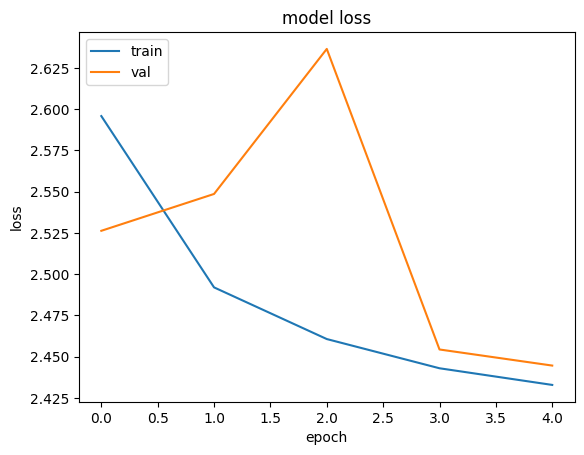

In [ ]:
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Ideally, we would find a curve that decrease the while the epochs increase (leftmost figure), like the one that we had in the previous run.
In most case, we can find results that are overfitting data (central figure) or not learning (rightmost figure):
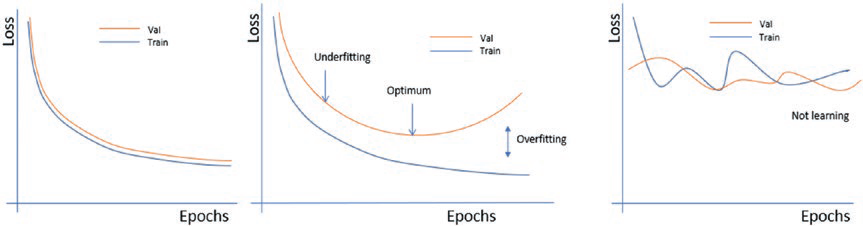

Finally, we retrieve the r2 score and we plot a subset of predicted data vs test data

In [ ]:
from sklearn.metrics import r2_score
preds = simple_model.predict(X_test)
print(r2_score(preds, y_test))



4336/4336 [==============================] - 7s 2ms/step
0.8532711323067254


Real values vs forecast for a subset of the predictions

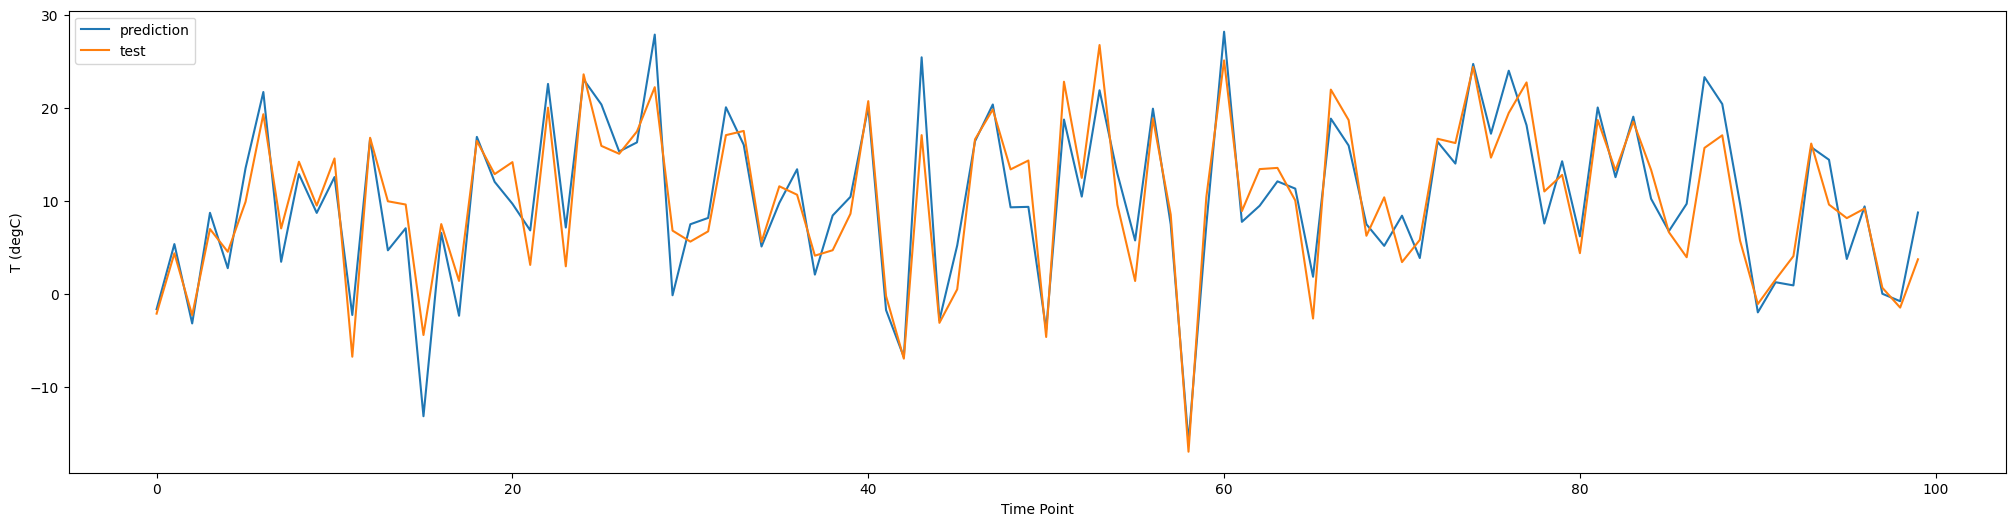

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))

# Get the indices of the array
indices = range(len(preds))

# Plot the array with its index on the x-axis
plt.plot(indices[0:100], y_test[0:100])
plt.plot(indices[0:100], preds[0:100])

# Add labels and title
plt.xlabel('Time Point')
plt.ylabel('T (degC)')
plt.legend(['prediction', 'test'], loc='upper left')
# Adjust width and height as needed

# Show plot
plt.show()